In [1]:
import random
from datetime import datetime

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

c:\python\python38\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from config import *

# Dataset

Using **CIFAR10** for our implementation.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Data Augmentation

In [5]:
from util import *

# Create Patches

This layer creates patches from input images. The layer also consists of two utility methods:
- `show_patched_image`: This utility function takes a batch of images and its corresponding patches, randomly choses a pair and plots it. This is useful for a sanity check.
- `reconstruct_from_patch`: This utility funciton takes the patches of a **single** image, and reconstructs it back into the original image. This is useful for the training monitor callback defined later.

In [6]:
from Patches import *

Index selected: 197.


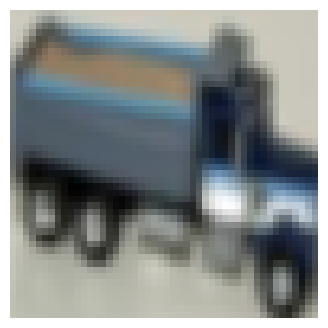

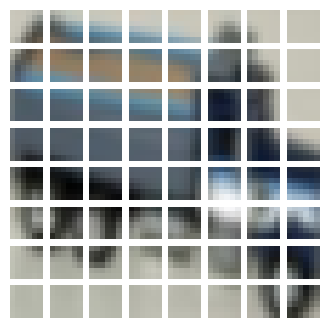

In [7]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmeneted_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = PatchesPre()

# Get the patches from the batched images.
patches = patch_layer(images=augmeneted_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmeneted_images, patches=patches)

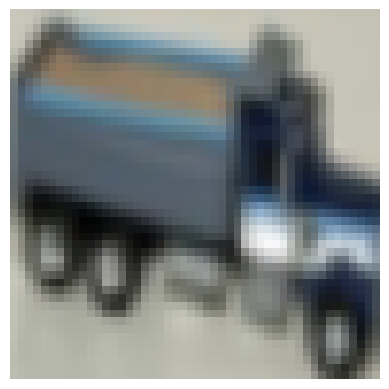

In [8]:
# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch Encoder

This layer deals with encoding the pathces and adding the positional embedding too. The layer holds two utility functions:
- `get_random_indices`: This function provides randomly sampled mask and unmask indices.
- `show_masked_image`: A utility function that plots a random masked image.

In [9]:
# Create the patch encoder layer.
patch_encoder = PatchEncoderPre()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

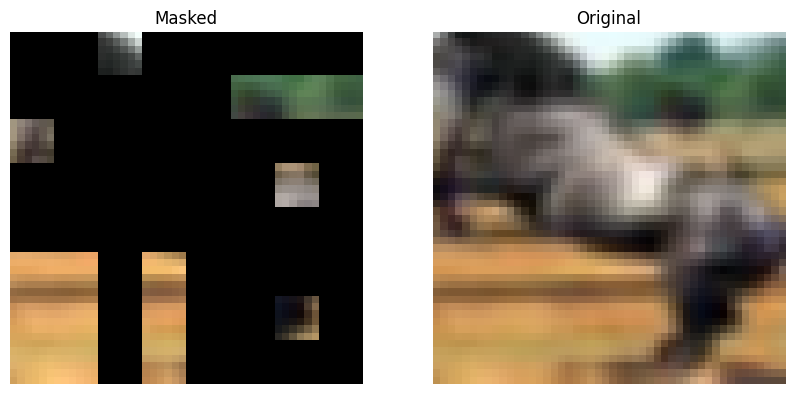

In [10]:
# Show a maksed patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmeneted_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

# MLP - Encoder - Decoder - MaskedAutoEncoder Model

In [11]:
from model import *

# Model init

In [12]:
keras.backend.clear_session()

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = PatchesPre()
patch_encoder = PatchEncoderPre()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

In [13]:
from TrainMonitor import *
# Taking a batch of test inputs to measure model's progress.


In [14]:
from WarmUpCosine import *

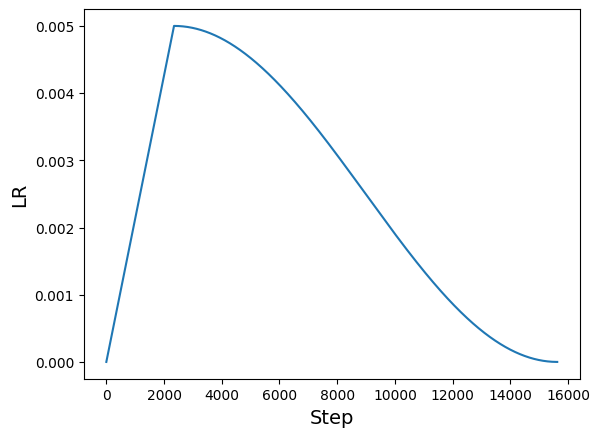

In [15]:
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_steps = int(total_steps * 0.15)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [16]:
timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

train_callbacks = [
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}"),
    TrainMonitor(test_ds, epoch_interval=5),
]

# Compilation and training

In [17]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

In [ ]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

In [19]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 1s 19ms/step - loss: 0.0146 - mae: 0.0856
Loss: 0.01
MAE: 0.09


# Downstrean Task

In [20]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_pre (PatchesPre)    (None, 64, 108)           0         
                                                                 
 patch_encoder_pre (PatchEnc  (None, 64, 128)          22252     
 oderPre)                                                        
                                                                 
 mae_encoder (Functional)    (None, None, 128)         990976    
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [21]:
train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [22]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 12s 57ms/step - loss: 2.2739 - accuracy: 0.1490 - val_loss: 2.0692 - val_accuracy: 0.2747
Epoch 2/50
157/157 [==============================] - 8s 52ms/step - loss: 1.9503 - accuracy: 0.3308 - val_loss: 1.8251 - val_accuracy: 0.3740
Epoch 3/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7950 - accuracy: 0.3842 - val_loss: 1.7266 - val_accuracy: 0.4032
Epoch 4/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7251 - accuracy: 0.4067 - val_loss: 1.6772 - val_accuracy: 0.4161
Epoch 5/50
157/157 [==============================] - 8s 54ms/step - loss: 1.6870 - accuracy: 0.4142 - val_loss: 1.6450 - val_accuracy: 0.4252
Epoch 6/50
157/157 [==============================] - 8s 53ms/step - loss: 1.6598 - accuracy: 0.4205 - val_loss: 1.6225 - val_accuracy: 0.4315
Epoch 7/50
157/157 [==============================] - 8s 53ms/step - loss: 1.6422 - accuracy: 0.4266 - val_loss: 1.6056 - val_accuracy: 0.435


KeyboardInterrupt



In [ ]:
downstream_model.save(f"linear_probe_{timestamp}", include_optimizer=False)